In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import h5py
from collections import defaultdict

from timeit import default_timer as timer

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder 

import torch
import torchvision.transforms as transforms
from skimage.util import random_noise

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from tensorflow.keras import layers, models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout, Reshape
from keras.optimizers import Adam
from keras.losses import mean_squared_error, categorical_crossentropy, binary_crossentropy
from keras.callbacks import EarlyStopping
from keras.metrics import MeanIoU, IoU

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose
from tensorflow.keras.metrics import Recall, Precision, MeanAbsoluteError
from tensorflow.keras.utils import plot_model


import torch
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim

import os
from glob import glob
import random
from random import shuffle
from tqdm import tqdm
%matplotlib inline
from PIL import ImageFile, Image


from torch_lr_finder import LRFinder
from torchview import draw_graph


from transforms import Resize, Rotate, VerticalFlip, HorizontalFlip, Normalize, ToTensor
from dataset import SurfaceDefectDetectionDataset, partitioning
from loss import WeightedBCELoss, TverskyLoss
from unet import UNet_2D
from metrics import performance_metrics 
from train import train_2D
from inference import plot_prediction_results, get_inference_performance_metrics




c:\Users\wfaiz\anaconda3\envs\pcb_proj\Lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
#check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available. Training on GPU ...')

CUDA is not available. Training on CPU ...


In [3]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(51)

In [4]:
batch_size = 32    # batch_size for the train and validation set
test_batch_size =1 # batch_size for the test set
num_workers = 0
n_epochs = 5
optimizer_type = 'Adam' """Either Adam or SGD, adjust the learning rate in the
                           "Specify the loss function and optimizer" section"""
threshold = 0.5   # Threshold value to create binary image 
lr_find = False   # Set to True to find the maximum learning rate
criterion_type = 'TverskyLoss'  ''' Adjust the penalties in the "Specify the loss 
                                  function and optimizer" section'''  
classes =['Blowhole', 'Crack','Free'] # classes/labels
split_ratio = [0.70, 0.10, 0.20]      # A list of the (train,val,test) split ratio

In [5]:
partition = partitioning(split_ratio)

Blowhole _  train:  80   val:  11   test:  24   total:  115
Crack _  train:  39   val:  6   test:  12   total:  57
Free _  train:  56   val:  7   test:  17   total:  80


In [6]:
# Construct the transformed dataset
surface_defect_dataset ={}
for p in ['train', 'val', 'test']:
    surface_defect_dataset[p] = SurfaceDefectDetectionDataset (partition[p], p)

C:\Users\wfaiz\Github/Magnetic-Tile-Surface-Defects/Notebooks/Magnetic-tile-defect-datasets-master


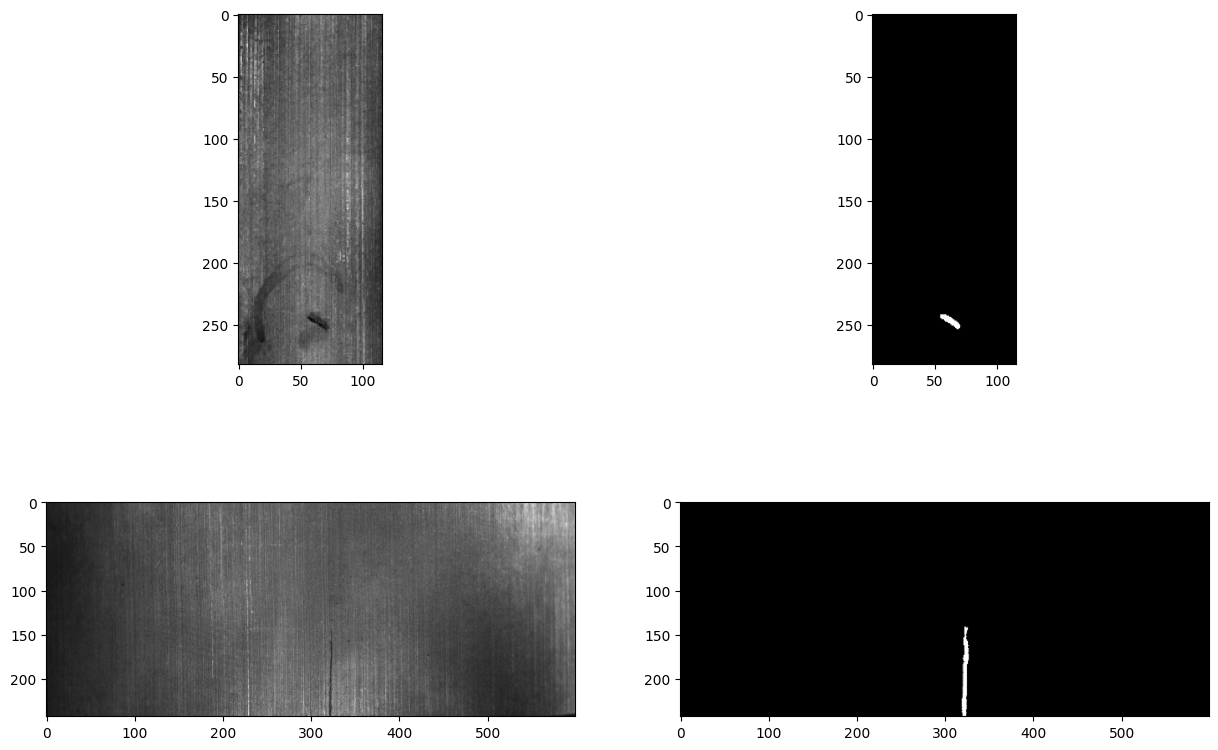

In [22]:
#parent_dir = os.join.path(osget(cw)
base_dir = os.path.expanduser('~\\Github/Magnetic-Tile-Surface-Defects/Notebooks/Magnetic-tile-defect-datasets-master')
images_path = [
    os.path.join(base_dir, 'MT_Blowhole/Imgs/exp1_num_4944'),
    os.path.join(base_dir, 'MT_Crack/Imgs/exp1_num_86828')
]
#Define the size of images
fig =  plt.figure(figsize=(15, 10))
n=len(images_path)
for i, im_path in enumerate(images_path):
    ax = fig.add_subplot(n,2,2*i+1) 
    plt.imshow(Image.open(im_path+'.jpg'), cmap='gray')
    ax = fig.add_subplot(n,2, 2*i+2)
    plt.imshow(Image.open(im_path+'.png'), cmap='gray')

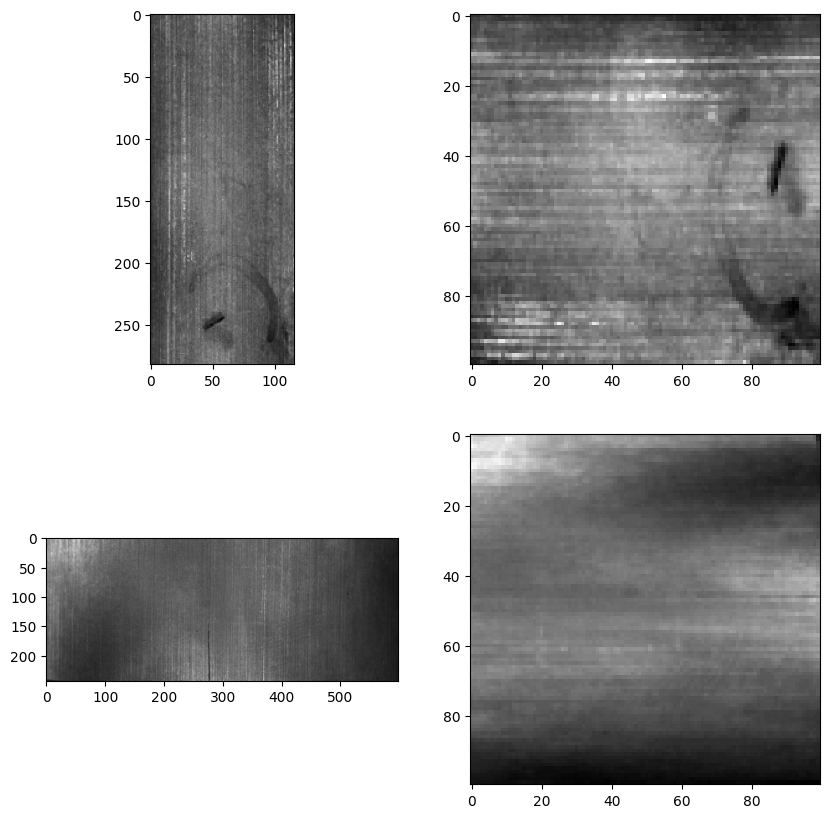

In [8]:
images_path = [
    os.path.join(base_dir, 'MT_Blowhole/Imgs/exp1_num_4944'),
            os.path.join(base_dir, 'MT_Crack/Imgs/exp1_num_86828')]
#Define the size of images
fig =  plt.figure(figsize=(10, 10))
n=len(images_path)
for i, im_path in enumerate(images_path):
    image = Image.open(images_path[i]+'.jpg')
    mask = Image.open(images_path[i]+'.png')
    t1 = HorizontalFlip()
    t2 = Resize((100,100))
    t3 = Rotate(90)
    ax1 = fig.add_subplot(n,2,2*i+1) 
    plt.imshow(t1(image), cmap='gray')  # Added by Ray
    ax2 = fig.add_subplot(n,2, 2*i+2)
    plt.imshow(t3(t2(image)), cmap='gray')

In [9]:
#image info

H = []
W = []
pair = []
for p in partition['train']:
  image = Image.open(p)
  W.append(image.size[0])
  H.append(image.size[1])
  pair.append(image.size)
print("maximum height:",max(H),"\tmaximum width:", max(W), "\tminimum height:", min(H), "\tminimum width:", min(W))

maximum height: 403 	maximum width: 610 	minimum height: 241 	minimum width: 112


In [10]:
print('Length of train dataset: ', len(surface_defect_dataset['train']))
print('Length of validation dataset: ', len(surface_defect_dataset['val']))
print('Length of test dataset: ', len(surface_defect_dataset['test']))

Length of train dataset:  175
Length of validation dataset:  24
Length of test dataset:  53


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

positive_weight = 0
negative_weight = 0
total_pixels = 0
for _, target in surface_defect_dataset['train']:
    positive_weight += ((target.cpu().numpy()) >= threshold).sum()
    negative_weight += ((target.cpu().numpy()) < threshold).sum()
    total_pixels += (224 * 224)
positive_weight /= total_pixels
negative_weight /= total_pixels
print('positive weight = ',positive_weight, '\tnegative weight = ', negative_weight)

positive weight =  0.001769542638483965 	negative weight =  0.998230457361516


In [12]:
loaders={}
loaders['train'] = torch.utils.data.DataLoader(surface_defect_dataset['train'], 
                                               batch_size=batch_size,
                                               shuffle = True,
                                               num_workers=num_workers)
loaders['val'] = torch.utils.data.DataLoader(surface_defect_dataset['val'], 
                                             batch_size=batch_size,
                                             shuffle=False, 
                                             num_workers=num_workers)
loaders['test'] = torch.utils.data.DataLoader(surface_defect_dataset['test'], 
                                              batch_size= test_batch_size, 
                                              shuffle=False, 
                                              num_workers=num_workers)

In [13]:
model = UNet_2D(1,1,32,0.2).to(device)
if train_on_gpu:
    model.cuda()

summary(model, (1, 224, 224), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 224, 224]             320
       BatchNorm2d-2         [32, 32, 224, 224]              64
              SiLU-3         [32, 32, 224, 224]               0
            Conv2d-4         [32, 32, 224, 224]           9,248
       BatchNorm2d-5         [32, 32, 224, 224]              64
         MaxPool2d-6         [32, 32, 112, 112]               0
            Conv2d-7         [32, 64, 112, 112]          18,496
       BatchNorm2d-8         [32, 64, 112, 112]             128
              SiLU-9         [32, 64, 112, 112]               0
           Conv2d-10         [32, 64, 112, 112]          36,928
      BatchNorm2d-11         [32, 64, 112, 112]             128
        MaxPool2d-12           [32, 64, 56, 56]               0
           Conv2d-13          [32, 128, 56, 56]          73,856
      BatchNorm2d-14          [32, 128,

In [16]:
model_graph = draw_graph(model, input_size=(32, 1, 224, 224), expand_nested=True)

KeyError: '1784004290192'


(process:216668): Pango-WARNING **: 14:31:53.862: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


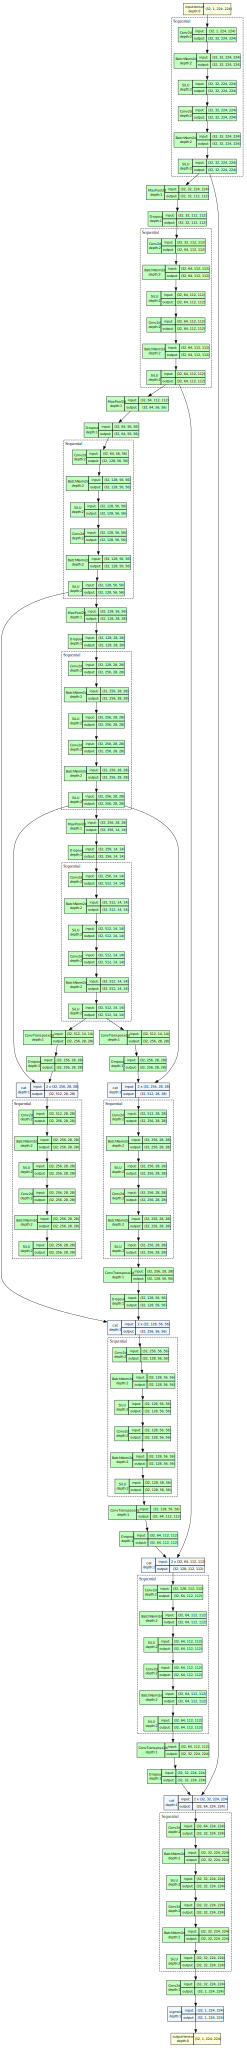

In [37]:
model_graph.visual_graph

In [15]:
if criterion_type == 'WeightedBCE':
    weight = np.array([negative_weight, positive_weight])
    weight = torch.from_numpy(weight)
    criterion = WeightedBCELoss(weights=weight)
else:
    criterion = TverskyLoss(1e-10,0.3,.7)
# Optimizer
if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
else:
    optimizer = optim.Adam(model.parameters(), lr = 0.002)

In [16]:
"""
If lr_find is True, after running this cell, assign the scheduler's max_lr to 
the suggested maximum lr and then set lr_find to False in the "Set the parameters"
section. Set the lr in the optimizer 1/10 of max_lr. Then re_run the code. 
"""
if lr_find == False:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02,
                                                    steps_per_epoch=len(loaders['train']),
                                                    epochs=n_epochs)     
else:
    #https://github.com/davidtvs/pytorch-lr-finder
    desired_batch_size, real_batch_size = batch_size, batch_size
    accumulation_steps = desired_batch_size // real_batch_size
    lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
    lr_finder.range_test(loaders['train'], end_lr=1, num_iter=100, step_mode='exp')
    lr_finder.plot() # to inspect the loss-learning rate graph
    lr_finder.reset() # to reset the model and optimizer to their initial state"""

In [17]:
model = train_2D(n_epochs, loaders, model, optimizer, criterion, train_on_gpu, 'model.pt')  

  0%|          | 0/6 [00:00<?, ?it/s]

=== Epoch #1 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 17%|█▋        | 1/6 [02:09<10:48, 129.72s/it]

Epoch: 1 	Training Loss: 0.9957 	Validation Loss: 0.9973
Validation loss decreased.  Saving model ...
=== Epoch #2 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 33%|███▎      | 2/6 [04:15<08:29, 127.31s/it]

Epoch: 2 	Training Loss: 0.9939 	Validation Loss: 0.9973
=== Epoch #3 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 50%|█████     | 3/6 [05:55<05:44, 114.97s/it]

Epoch: 3 	Training Loss: 0.9935 	Validation Loss: 0.9971
Validation loss decreased.  Saving model ...
=== Epoch #4 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 67%|██████▋   | 4/6 [07:49<03:48, 114.45s/it]

Epoch: 4 	Training Loss: 0.9934 	Validation Loss: 0.9966
Validation loss decreased.  Saving model ...
=== Epoch #5 ===
=== Training ===
1 / 6...
=== Validation ===
1 / 1...


 83%|████████▎ | 5/6 [09:24<01:52, 112.84s/it]

Epoch: 5 	Training Loss: 0.9928 	Validation Loss: 0.9964
Validation loss decreased.  Saving model ...


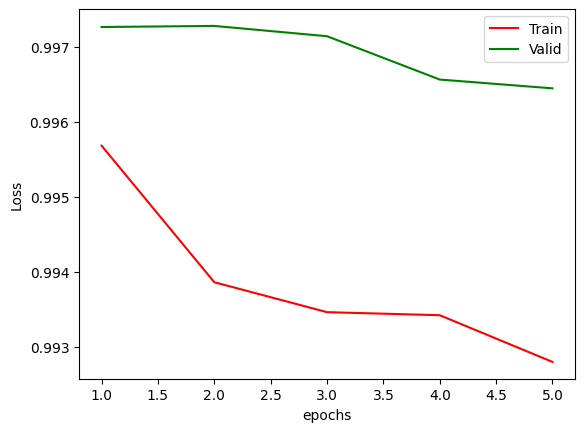

In [18]:
# plot the variation of train and validation losses vs n_epochs
loss=pd.read_csv('loss_epoch.csv',header=0,index_col=False)
plt.plot(loss['epoch'],loss['Training Loss'],'r',loss['epoch'],loss['Validation Loss'],'g')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(labels=['Train','Valid'])
plt.savefig('loss_epoch.png')

In [19]:
# load the model that got the minimum validation loss
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

c:\Users\wfaiz\Github\Magnetic-Tile-Surface-Defects\Notebooks\Application\inference.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(15,4))


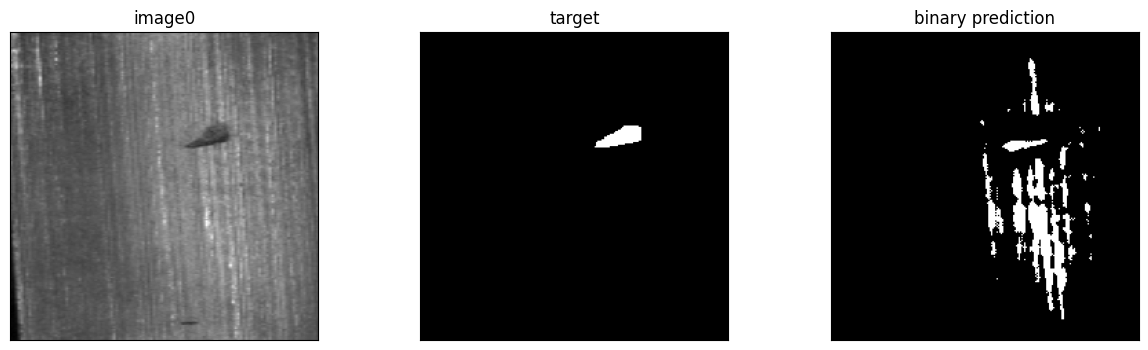

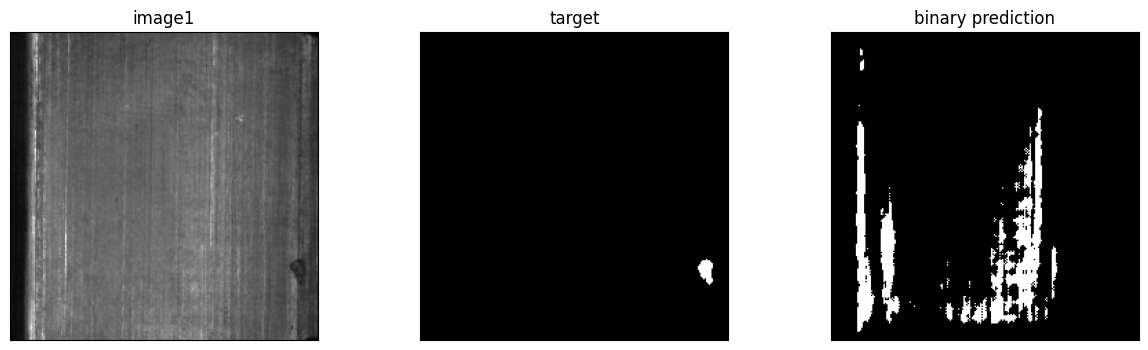

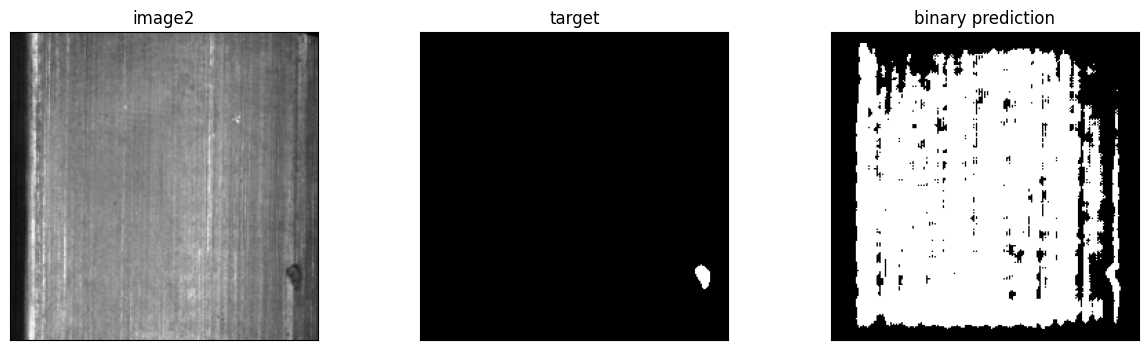

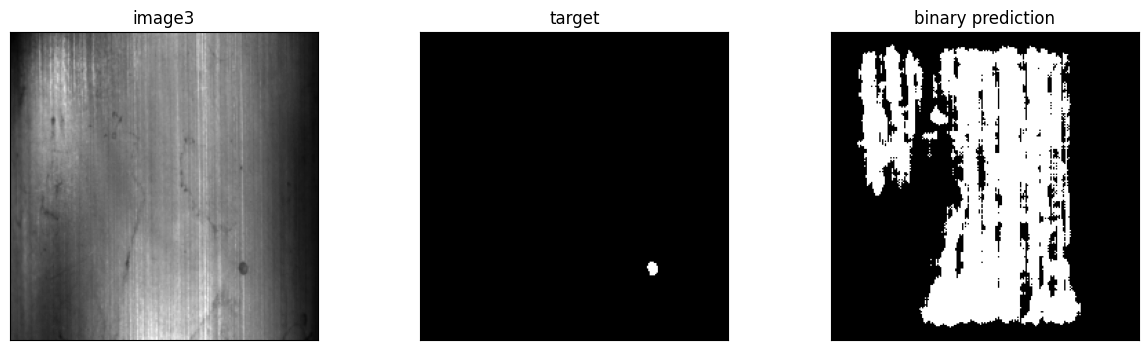

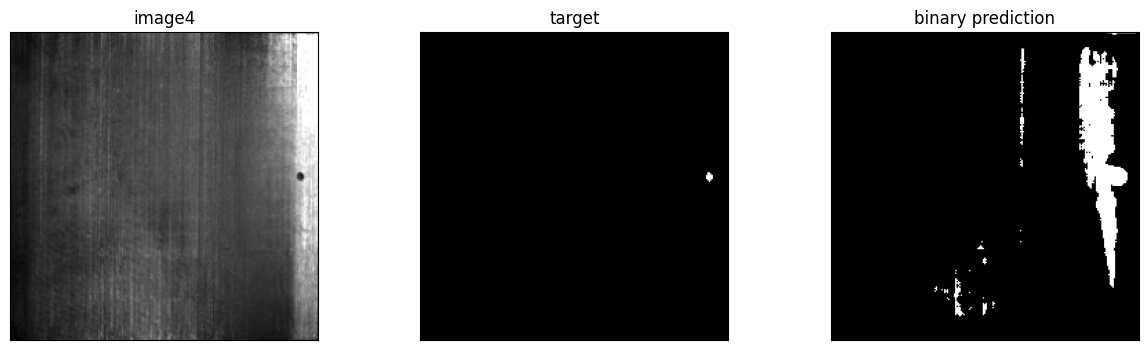

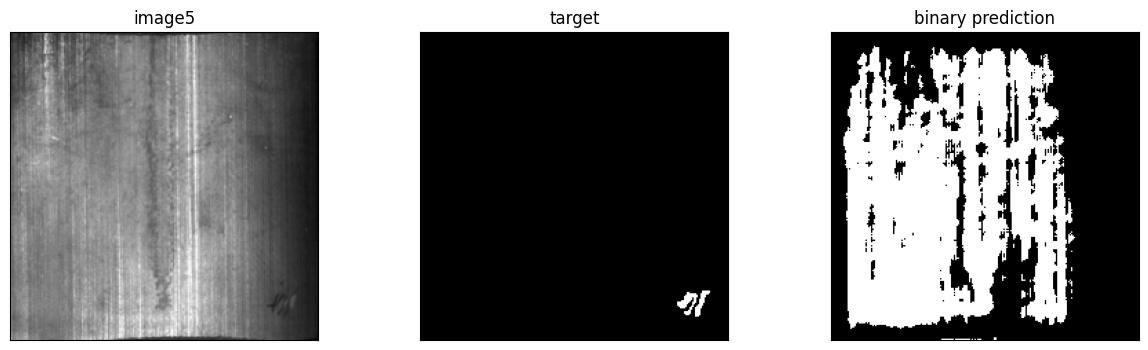

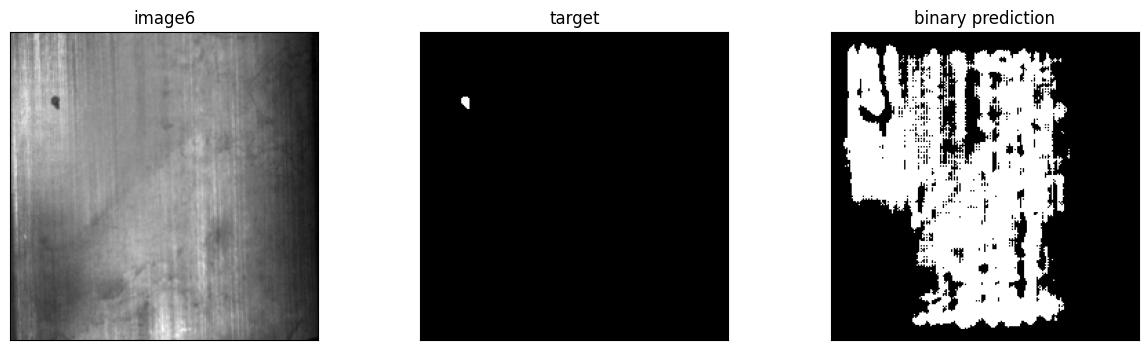

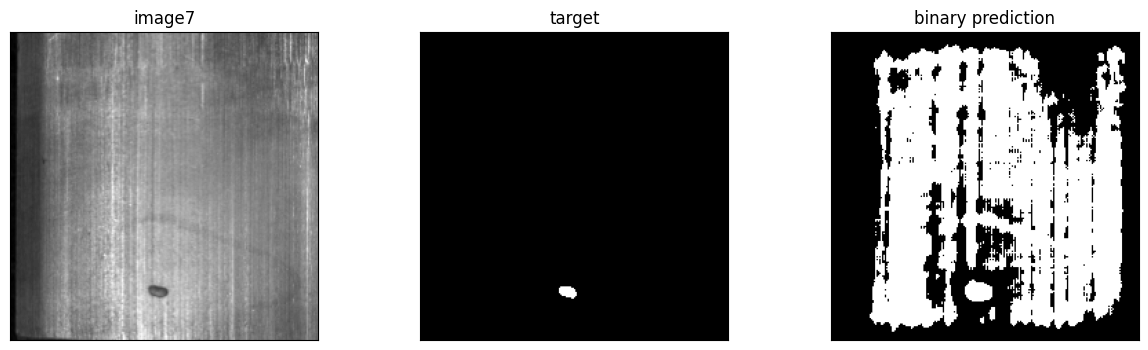

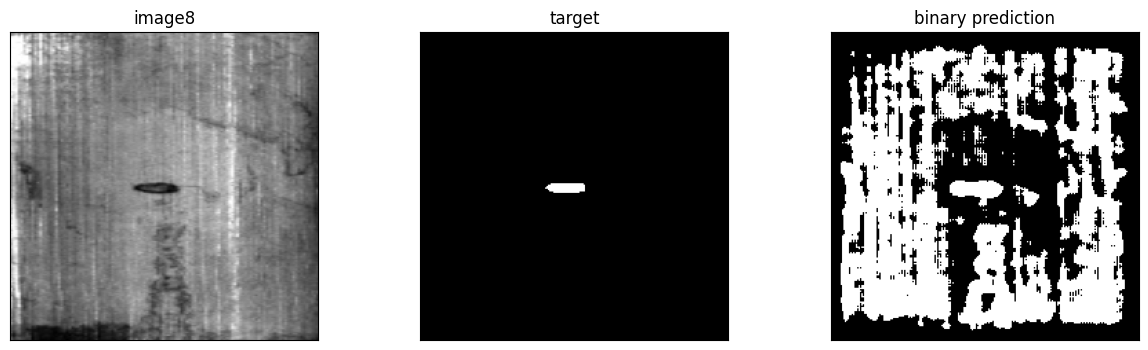

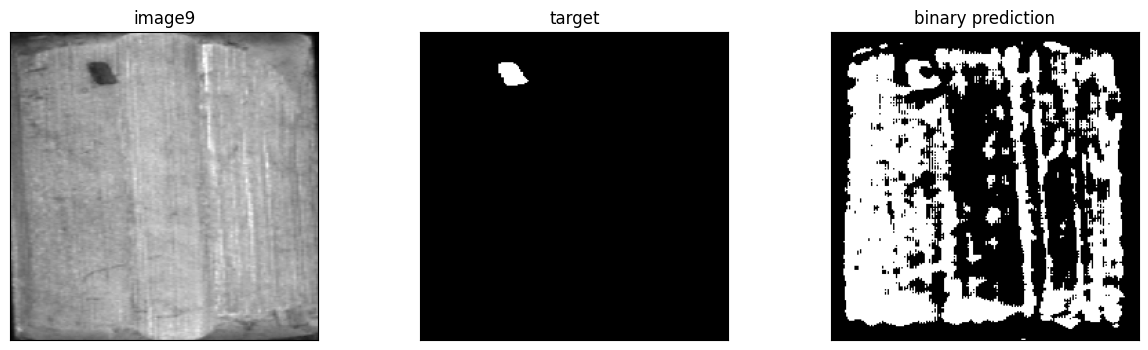

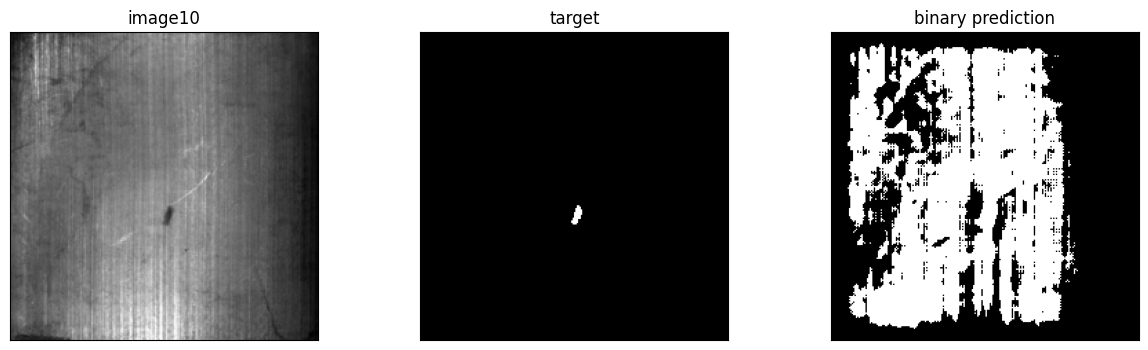

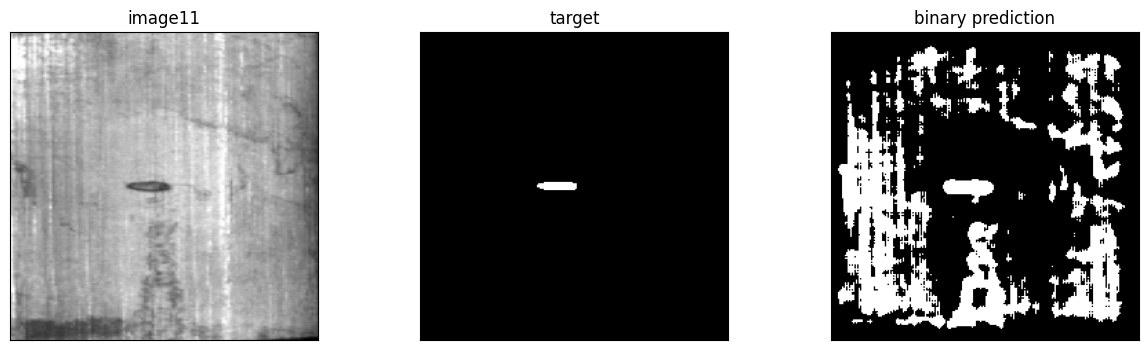

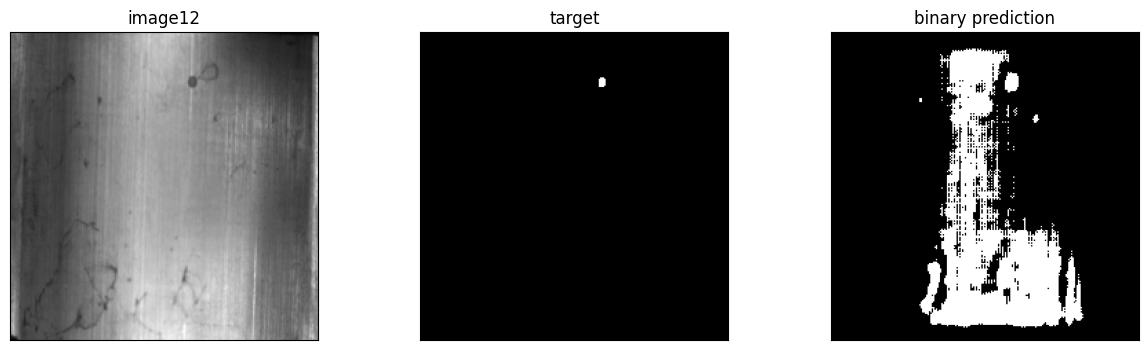

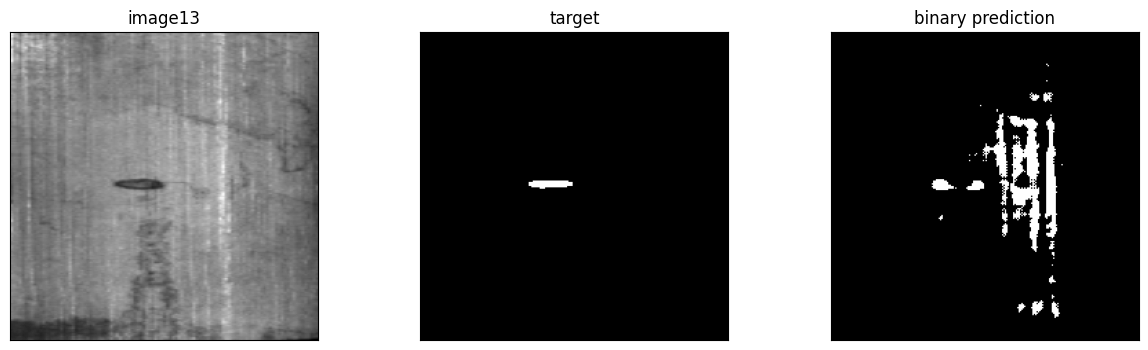

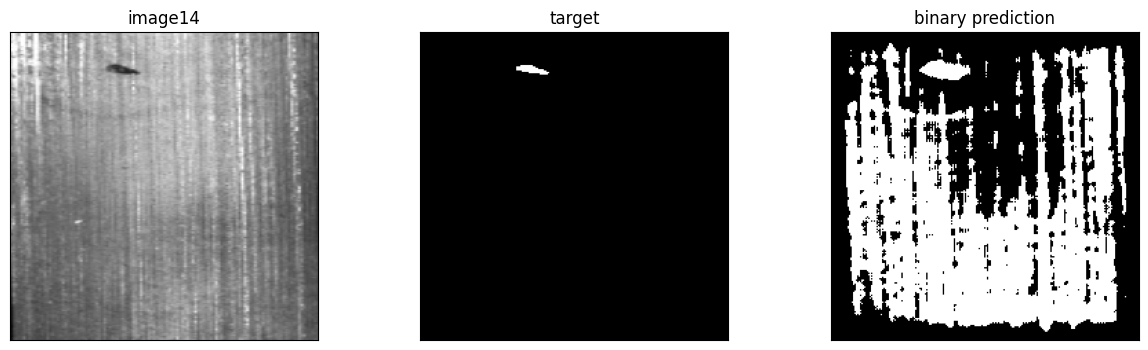

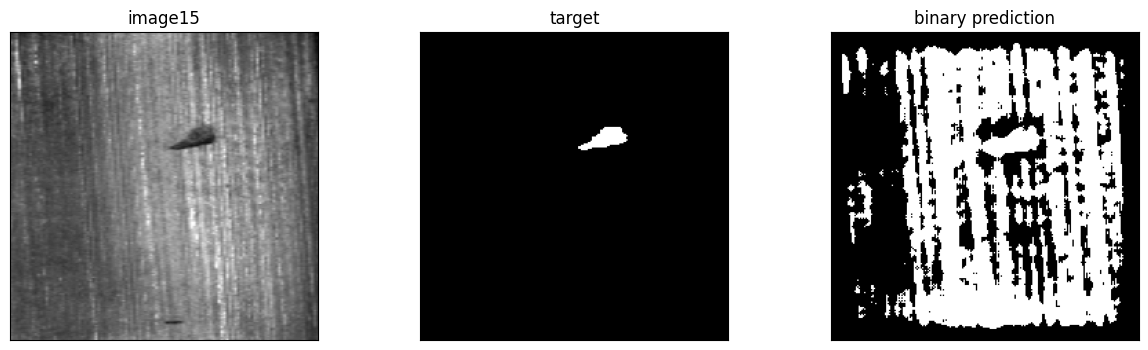

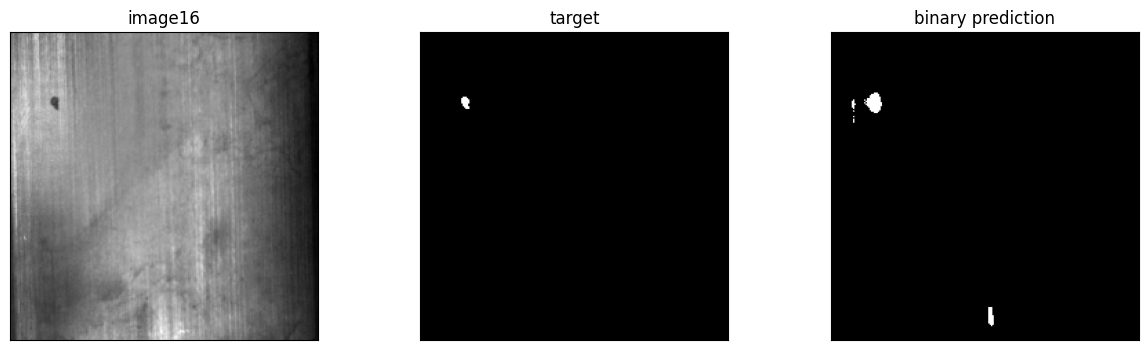

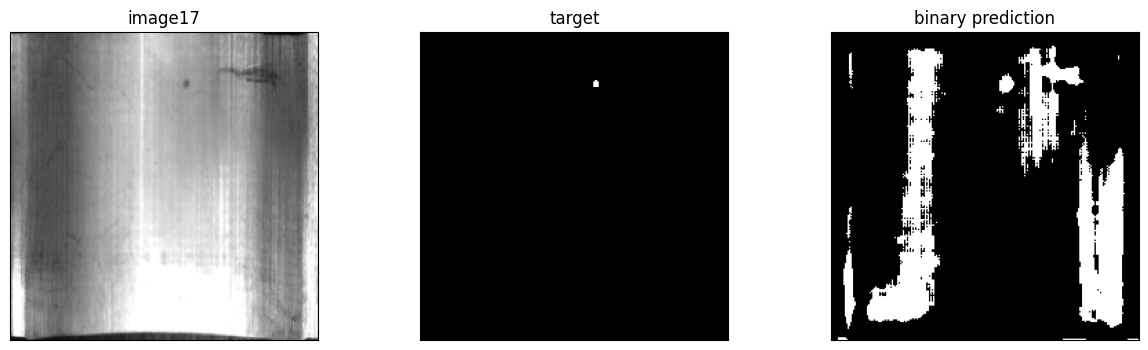

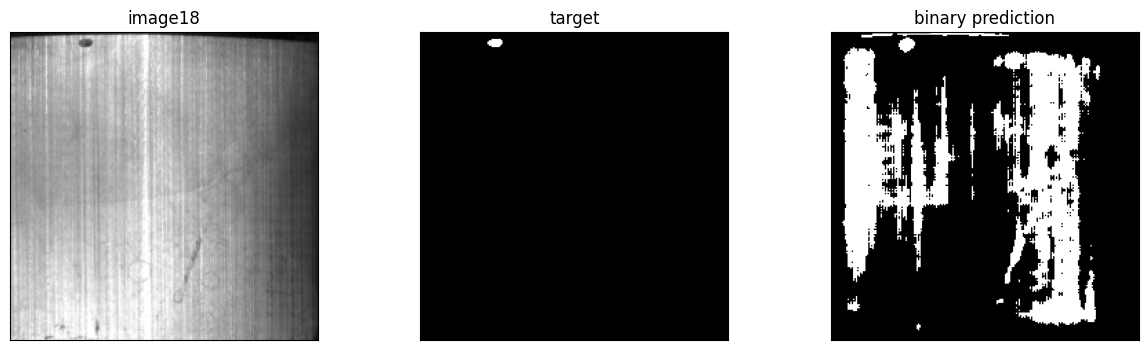

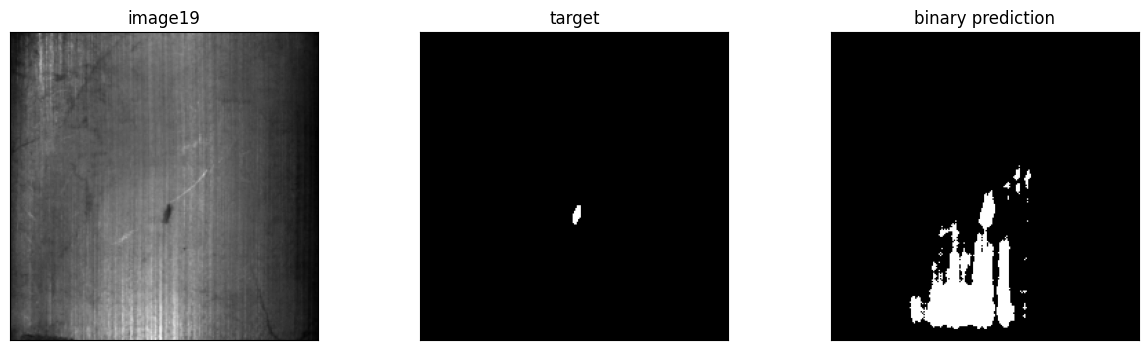

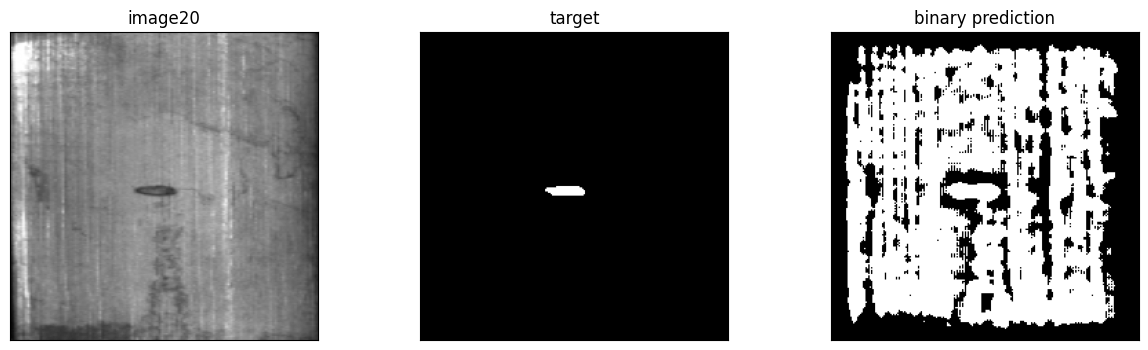

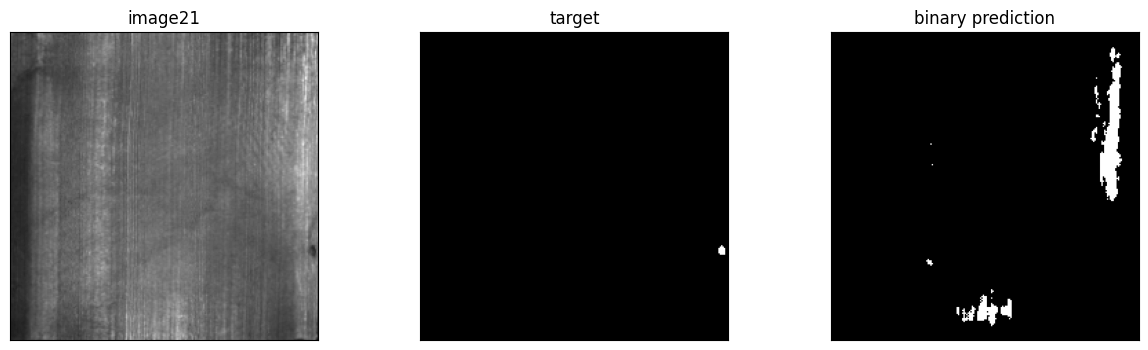

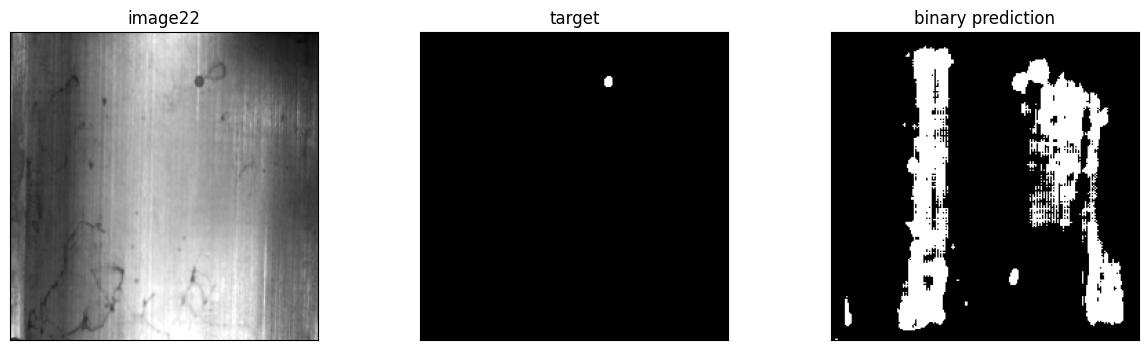

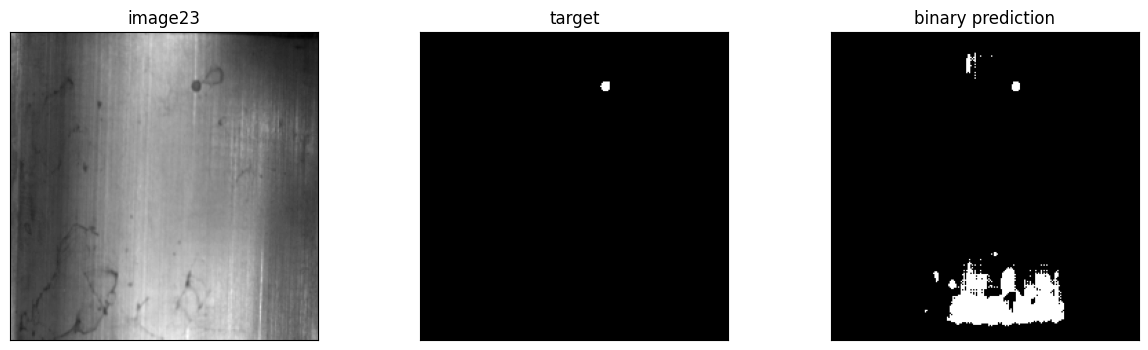

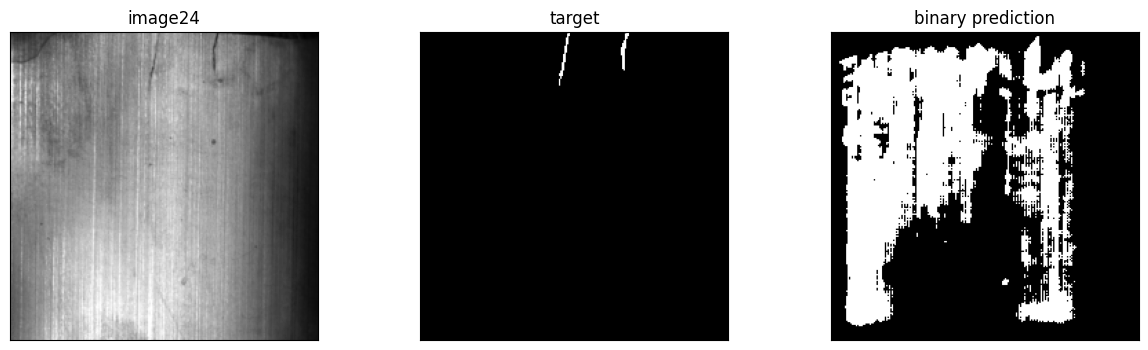

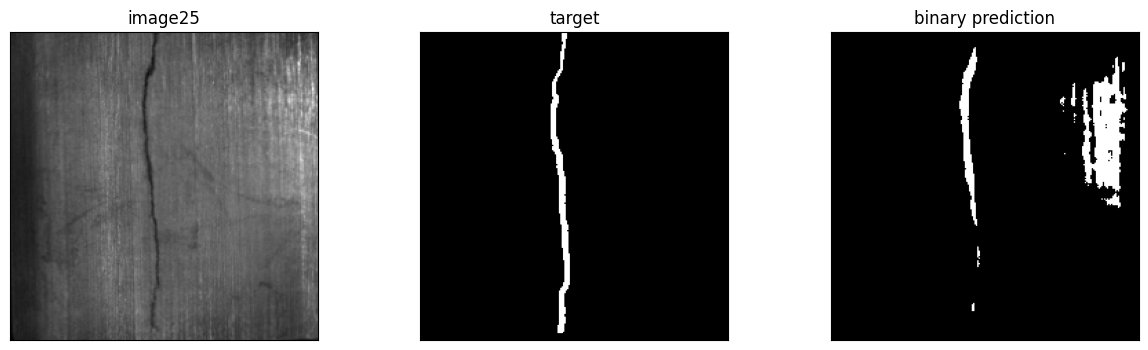

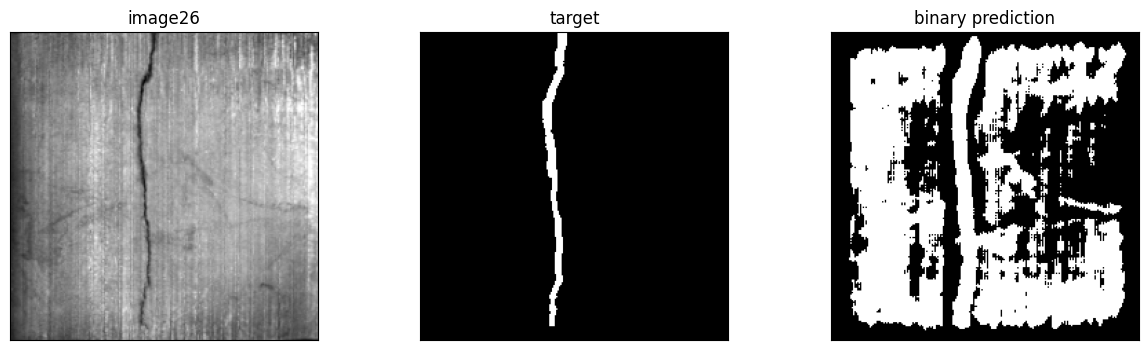

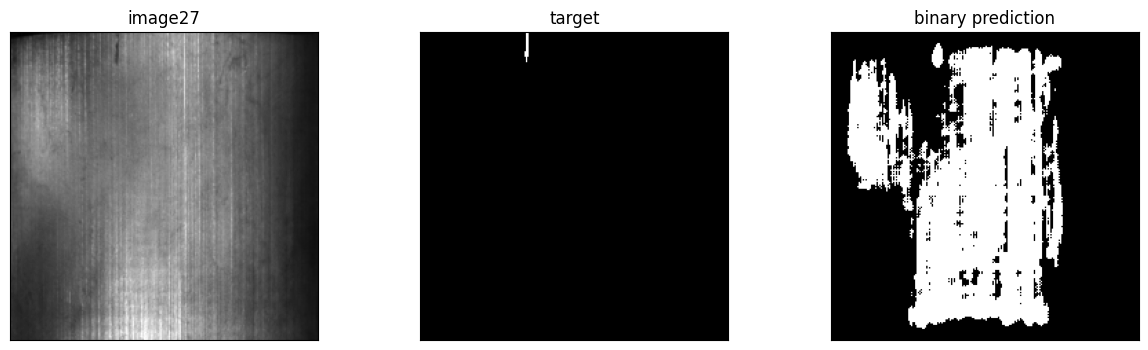

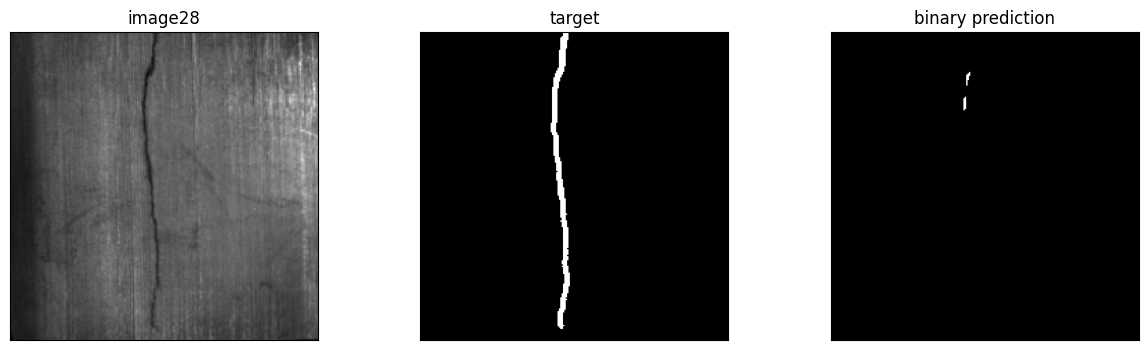

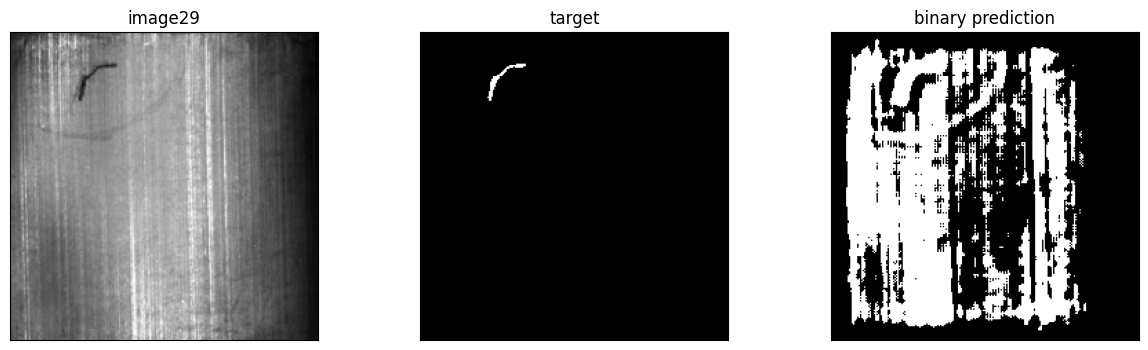

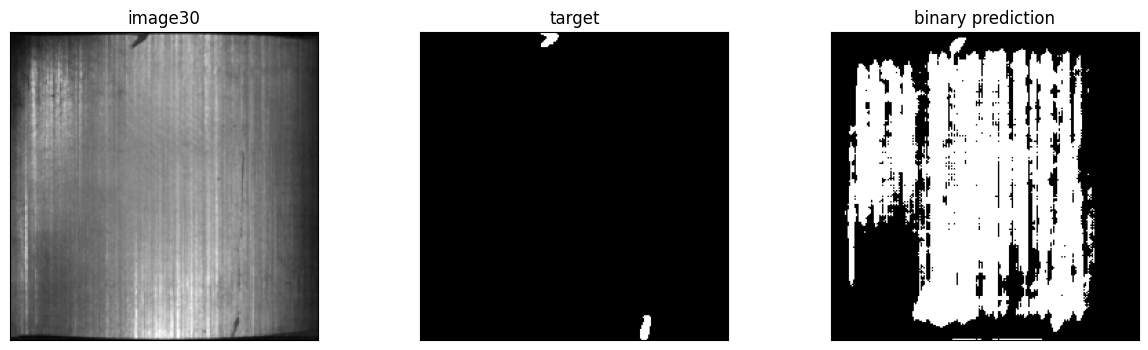

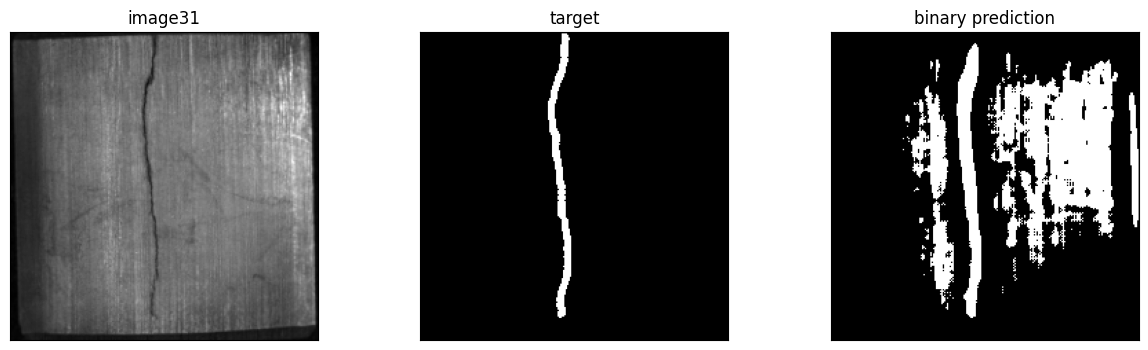

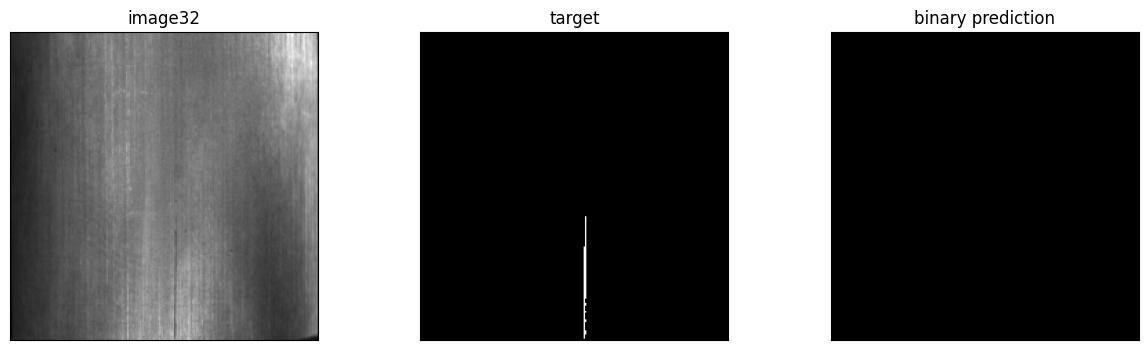

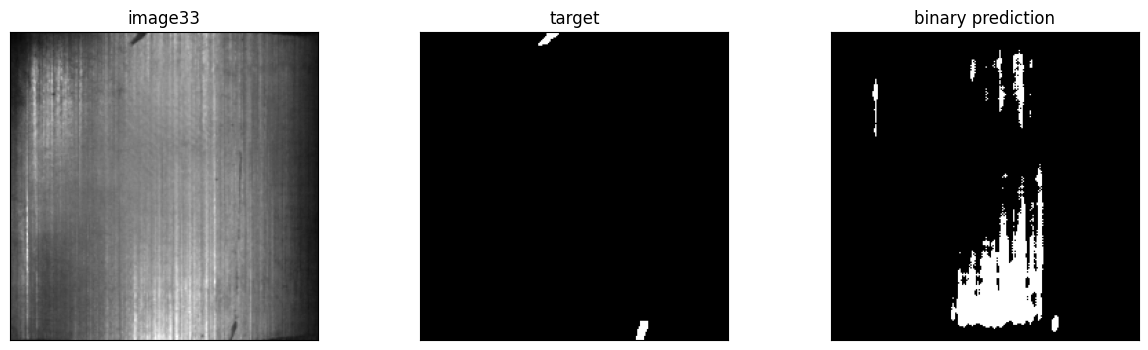

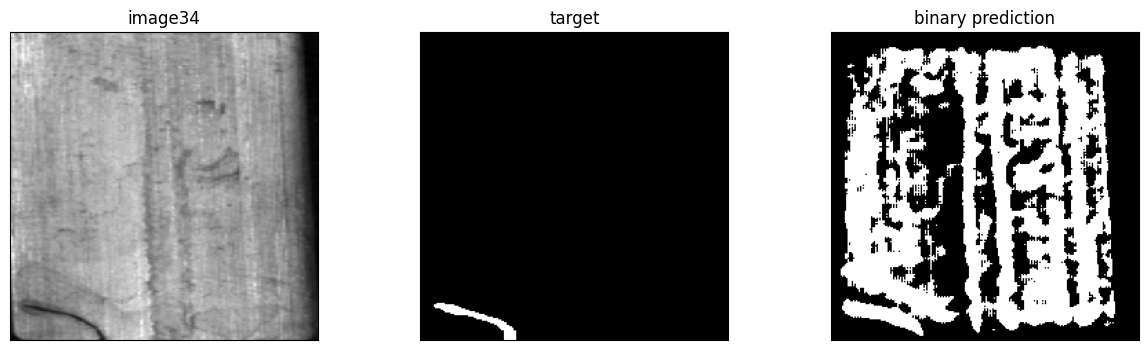

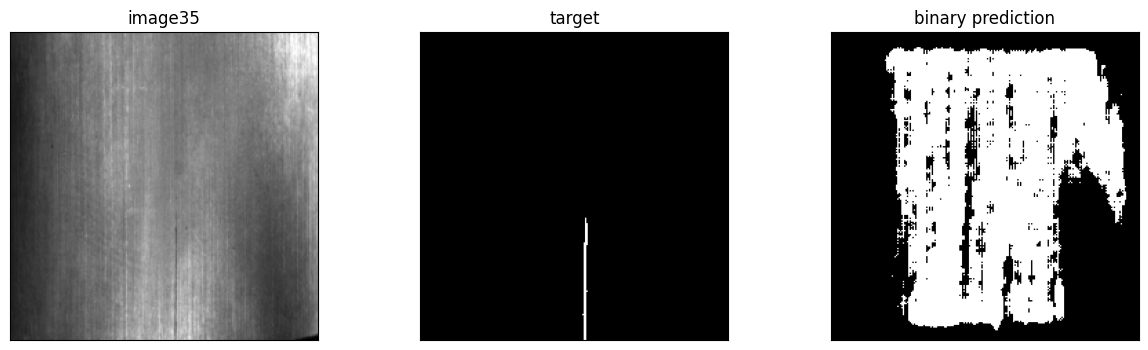

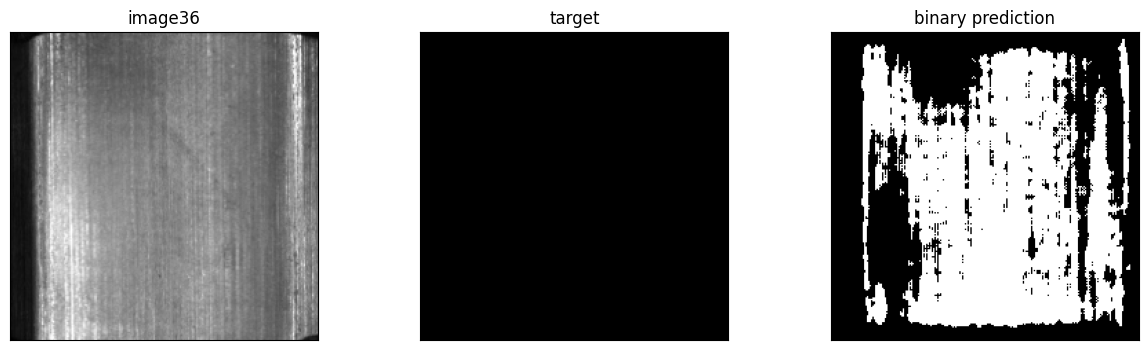

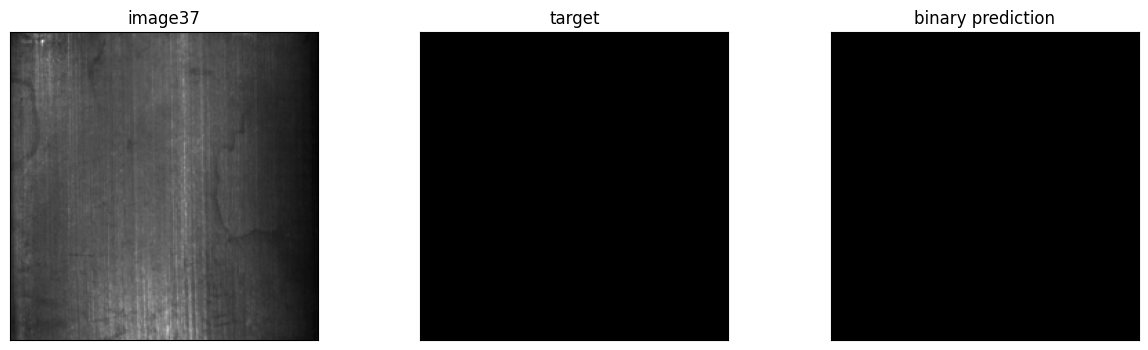

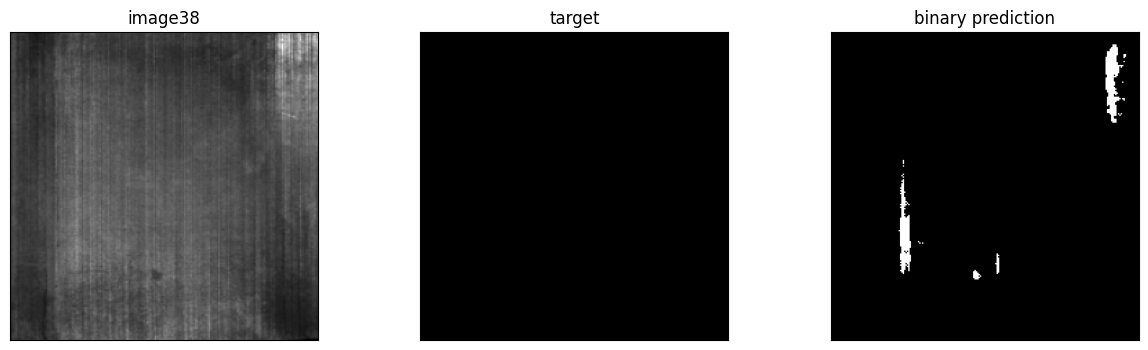

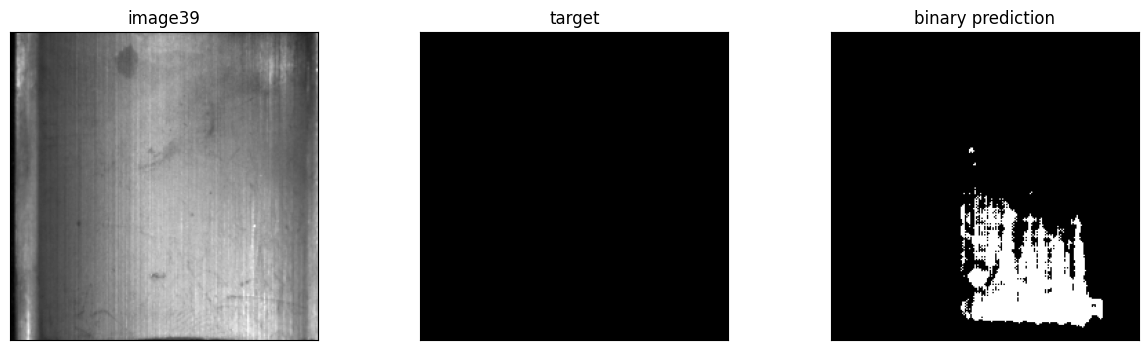

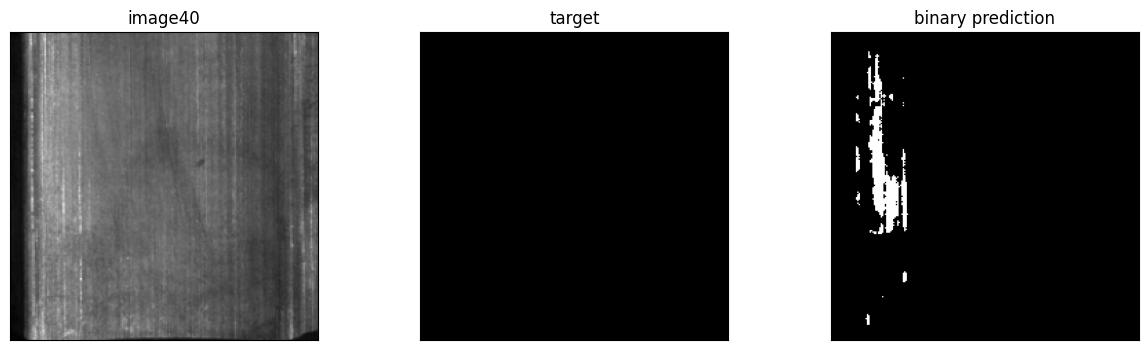

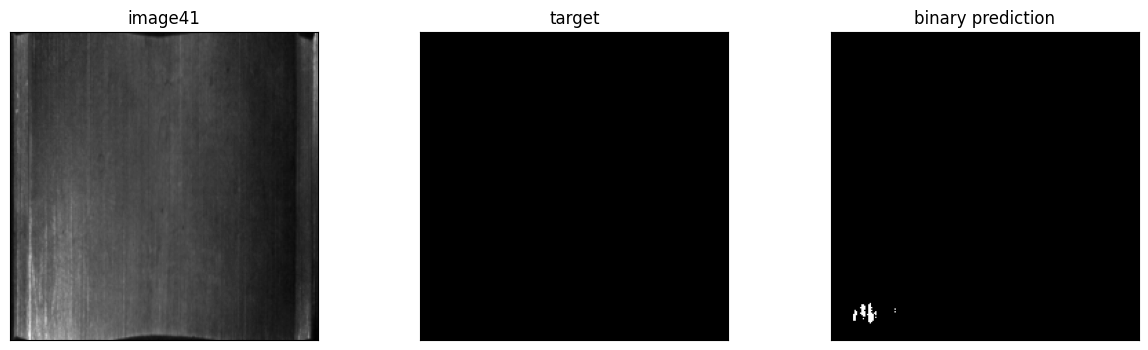

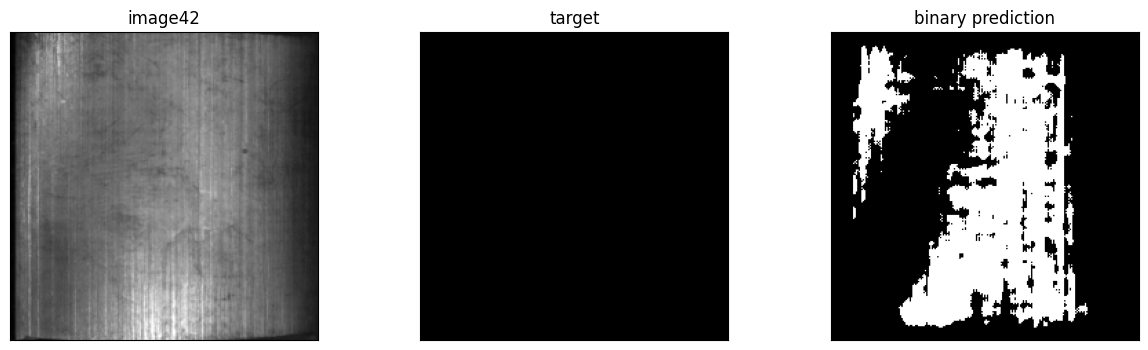

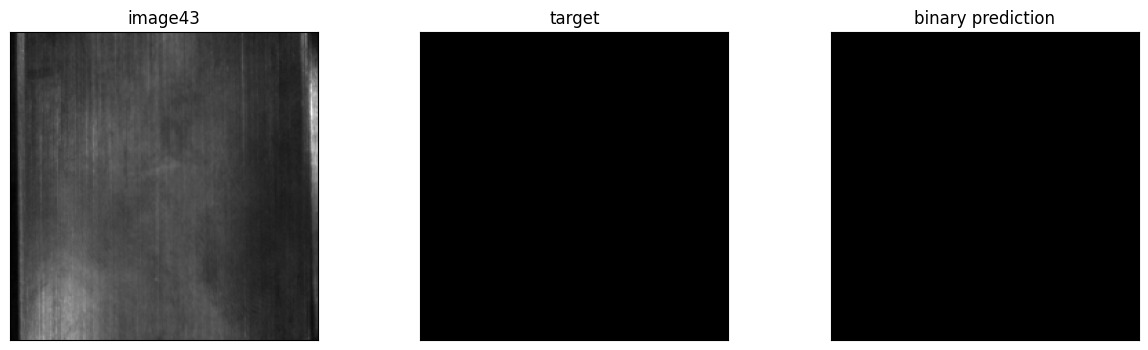

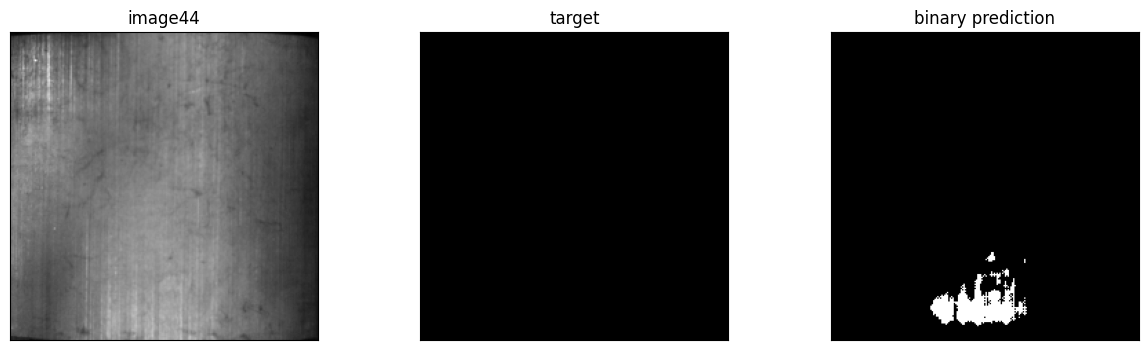

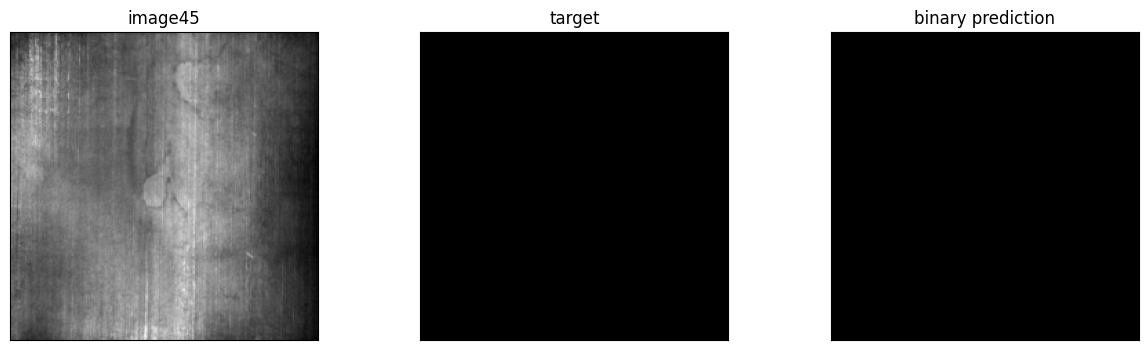

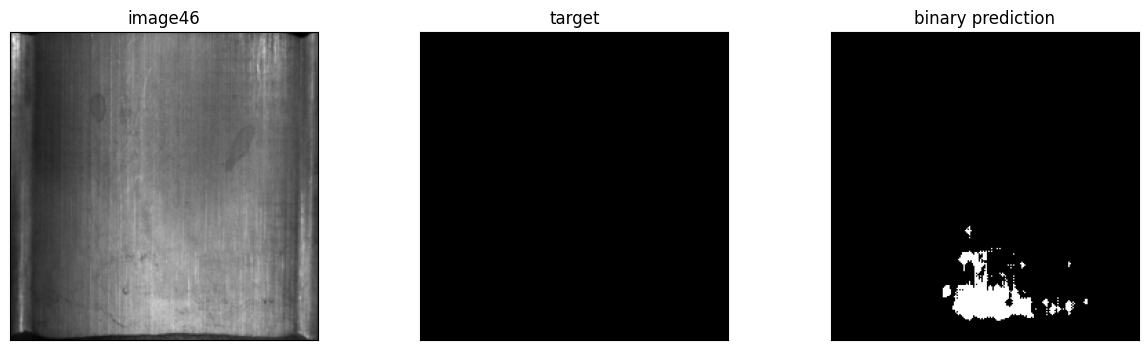

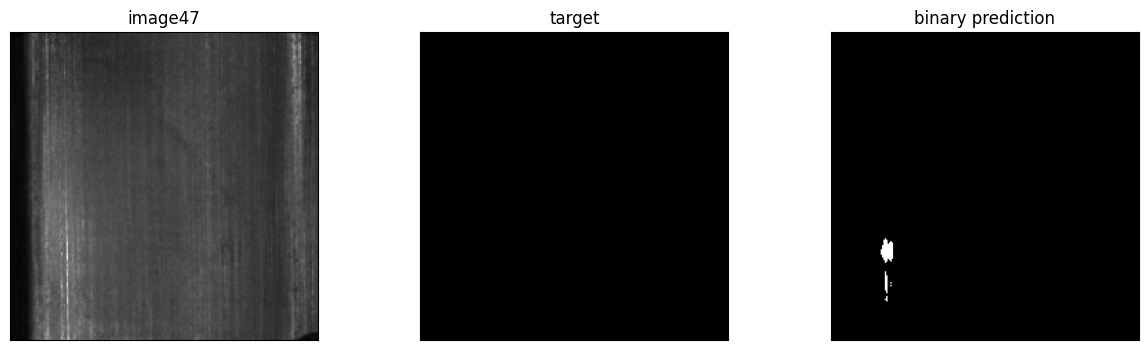

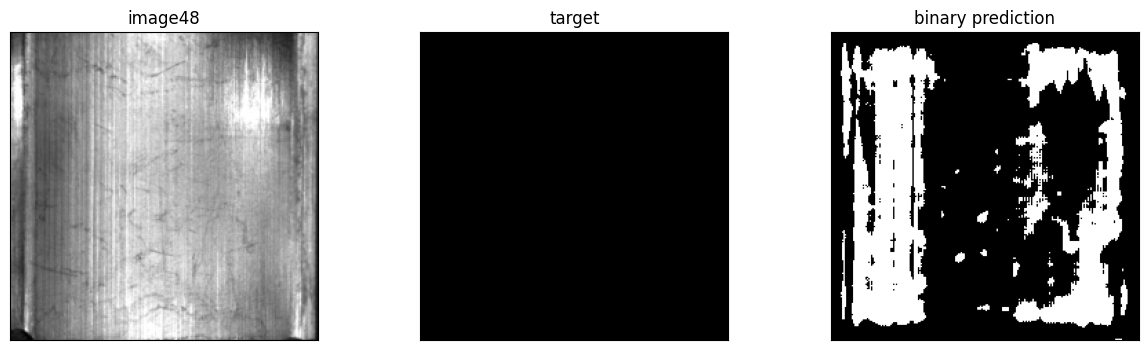

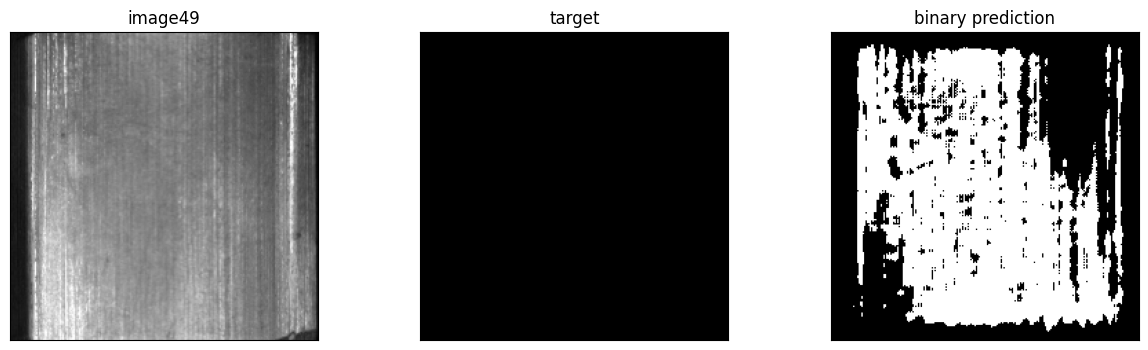

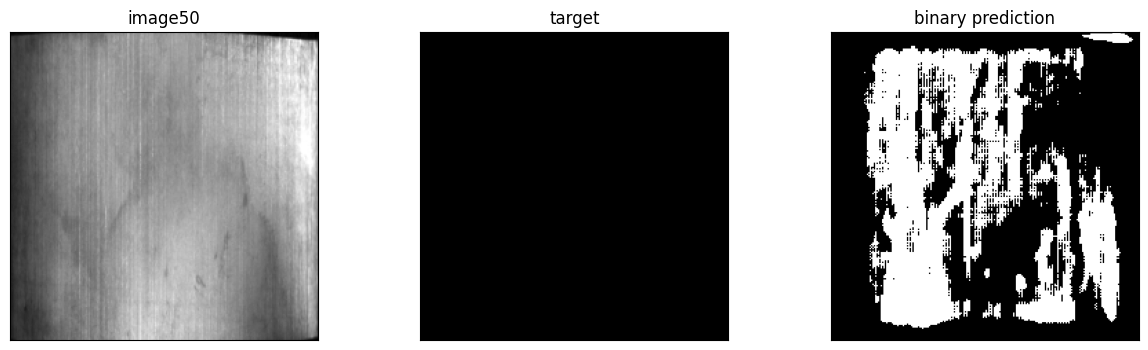

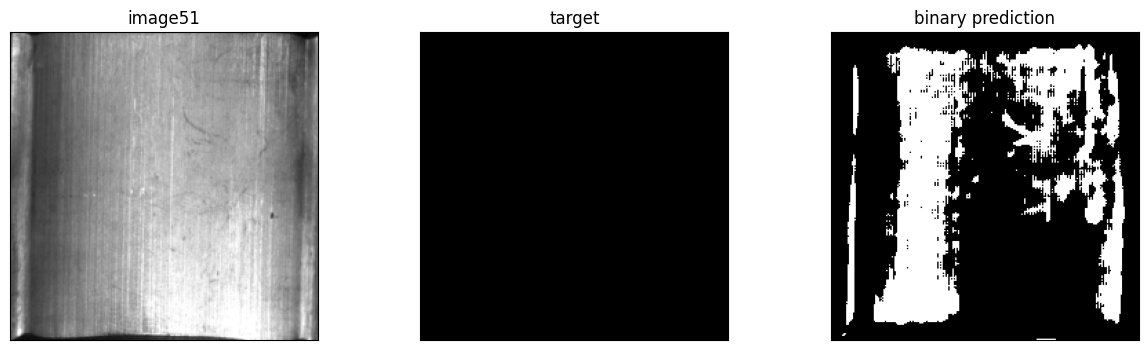

<Figure size 1500x400 with 0 Axes>

In [20]:
plot_prediction_results(model, train_on_gpu, loaders['test'], threshold)

In [21]:
df = get_inference_performance_metrics(model, train_on_gpu, loaders['test'], threshold)
df.describe()

specificity    sensitivity      precision   F1_score      F2_score  \
count    53.000000   5.300000e+01   5.300000e+01  53.000000  5.300000e+01   
mean      0.065082   4.592243e-02   2.070052e-03   0.023783  6.205853e-03   
std       0.140453   6.852385e-02   7.059318e-03   0.071330  1.826059e-02   
min       0.009012  2.749792e-110  2.015496e-112   0.000104  7.198755e-13   
25%       0.020593   1.840889e-27   1.349303e-29   0.000591  9.231453e-09   
50%       0.027001   2.459416e-02   1.875874e-04   0.003322  1.194126e-03   
75%       0.056602   5.882360e-02   8.095593e-04   0.022222  4.080523e-03   
max       0.946794   3.102410e-01   3.738657e-02   0.500001  1.261327e-01   

                DSC     F_beta           MAE        acc  
count  5.300000e+01  53.000000  5.300000e+01  53.000000  
mean   3.896215e-03   0.023090  2.099237e-02   0.064987  
std    1.070644e-02   0.071223  3.434372e-02   0.139879  
min    7.198755e-13   0.000068  2.567401e-10   0.009012  
25%    9.231453e-09   0.000385  2.012159e-03   0.020593  
50%    4.880954e-04   0.002755  1.065490e-02   0.026936  
75%    1.716248e-03   0.022222  2.279981e-02   0.056687  
max    6.673145e-02   0.500000  2.096623e-01   0.942582